In [1]:
import os
import math

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
#matplotlib inline

['solidYellowCurve.jpg', 'solidYellowLeft.jpg', 'solidYellowCurve2.jpg', 'solidWhiteRight.jpg', 'whiteCarLaneSwitch.jpg', 'solidWhiteCurve.jpg']
Type: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


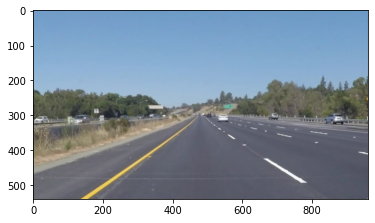

In [2]:
image = mpimg.imread("test_images/solidYellowLeft.jpg")

print(os.listdir('test_images/'))

print('Type:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)

In [3]:
a = np.array([[1,2],[1,2],[1,2]])
x, y = np.mean(a, axis=0)
print(x, y)

1.0 2.0


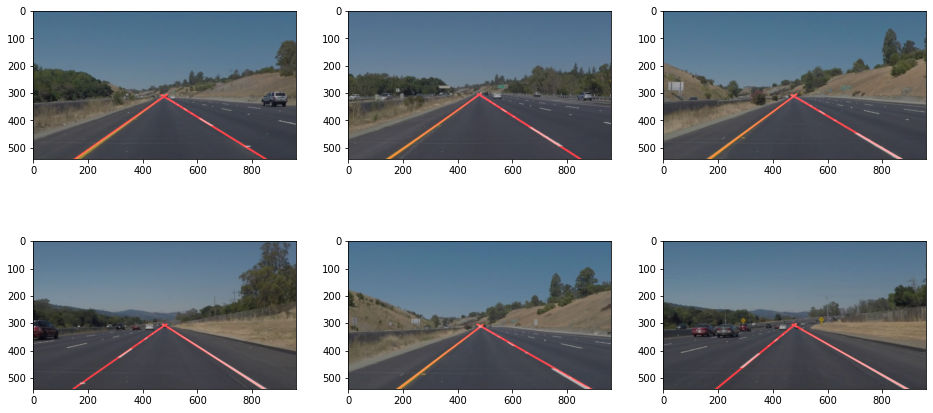

In [4]:
def slope_intercept(x1,y1,x2,y2):
    m = (y2-y1)/(x2-x1)
    b = y1-m*x1
    return m, b

def average_slope_intercept(lines):
    slope_intercepts = [slope_intercept(x1,y1,x2,y2) for x1,y1,x2,y2 in lines]
    m, b = np.mean(slope_intercepts,axis=0)
    return m, b

def points_from_slope_intercept(img, m, b):
    x1, x2 = 0, img.shape[1]
    y1, y2 = b, m*x2+b
    return x1, x2, y1, y2
        

def lane_image_from_lines(img, lines):
    # sort lines into left and right by their slope
    left, right = [], []
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope, _ = slope_intercept(x1,y1,x2,y2)
            if -0.2 > slope or slope > 0.2:
                if slope < 0:
                    right.append((x1,y1,x2,y2))
                else:
                    left.append((x1,y1,x2,y2))
        
    # draw the left and right lange from the averages
    line_image = np.zeros_like(img)           
    if len(left) > 0:
        left_slope, left_intercept = average_slope_intercept(left)
        x1, x2, y1, y2 = points_from_slope_intercept(img, left_slope, left_intercept)
        cv2.line(line_image, (int(x1),int(y1)), (int(x2),int(y2)), (255,0,0), 5)
    if len(right) > 0:
        right_slope, right_intercept = average_slope_intercept(right)
        x1, x2, y1, y2 = points_from_slope_intercept(img, right_slope, right_intercept)
        cv2.line(line_image, (int(x1),int(y1)), (int(x2),int(y2)), (255,0,0), 5)
    
    return line_image
    
def region_of_interest_mask(img):
    mask = np.zeros_like(img)
    imshape = image.shape
    vertices = np.array([[(imshape[1]/2,imshape[0]*0.55), (imshape[1],imshape[0]), (0, imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, 255)
    return mask

def find_lane_lines(img):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    region_mask = region_of_interest_mask(gray)
    
    blurred = cv2.GaussianBlur(gray,
                               (3,3),
                               cv2.BORDER_DEFAULT)
    
    edges = cv2.Canny(blurred,
                    threshold1=150,
                    threshold2=300)
    
    masked_edges = cv2.bitwise_and(edges, region_mask)
    
    lines = cv2.HoughLinesP(masked_edges,
                            rho=1,
                            theta=1/180*math.pi,
                            threshold=35,
                            minLineLength=100,
                            maxLineGap=100)
    
    line_image = lane_image_from_lines(img, lines)
    region_mask = region_of_interest_mask(line_image)
    masked_line_image = cv2.bitwise_and(line_image, region_mask)
    return masked_line_image

fig = plt.figure(figsize=(16,12))
image_paths = os.listdir('test_images')

for i in range(len(image_paths)):
    image_path = os.path.join('test_images', image_paths[i])
    if not image_path.endswith('.jpg'):
        print("skipping", image_path)
        continue
        
    image = mpimg.imread(image_path)
    line_image = find_lane_lines(image)
    combo = cv2.addWeighted(line_image, 1, image, 0.7, 0)
    fig.add_subplot(3, 3, i+1)
    plt.imshow(combo,cmap='gray')
               
plt.show()

In [5]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [6]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    line_image = find_lane_lines(image)
    combo = cv2.addWeighted(line_image, 1, image, 0.7, 0)
    return combo

In [7]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,10)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   9%|▊         | 19/221 [00:00<00:01, 189.71it/s, now=None]

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: user 1.37 s, sys: 332 ms, total: 1.7 s
Wall time: 2.01 s


In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [9]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   0%|          | 0/681 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
CPU times: user 4.72 s, sys: 1.33 s, total: 6.04 s
Wall time: 6.54 s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))